# Setup

## Imports

In [5]:
from typing import List

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches

from minisom import MiniSom
from sklearn.svm import OneClassSVM

print("Libraries imported.")

Libraries imported.


## Constants

In [20]:
# Filepaths
DATA_DIRECTORY = r"..."
IMAGE_EXPORT_DIRECTORY = r"..."

# Constants
TEST_TRAIN_SPLIT = 0.1
RANDOM_SEED = 1     # for reproducibility
WINDOW = 300    # rolling window to smoothen plots

# MODEL HYPERPARAMETERS
SOM_MAP_X_DIMENSION = 50      # 50 as taken from research paper
SOM_MAP_Y_DIMENSION = 50     # 50 as taken from research paper
SOM_TRAINING_EPOCHS = 10000

SVM_KERNEL = "rbf"
SVM_NU = 0.01

# Feature selection and mapping to colors
COLORMAP = {
    "A_3": "m",
    "B_4": "y",
    "C_4": "tab:orange",
    "L_1": "k",
    "L_3": "b",
    "L_4": "g",
    "L_7": "r",
    "L_9": "c",
}
COLS_TO_INCLUDE = list(COLORMAP.keys())

print("Constants set.")

Constants set.


## Plotting functions

In [7]:
def plot_deviation_curve(deviations: List[pd.DataFrame], anomaly_localization: List[pd.DataFrame], experiment_names: List[str],
                         colormap: dict, filepath: str):
    """"""
    x_dim, y_dim = 2, 4

    fig, ax = plt.subplots(x_dim, y_dim)
    fig.set_size_inches(y_dim * 3, x_dim * 3)

    for i, dataset in enumerate(deviations):
        row_idx = 0 if (i < y_dim) else 1
        col_idx = i % y_dim

        axis = ax[row_idx, col_idx]

        colors_per_datapoint = [colormap[x] for x in anomaly_localization[i]]
        axis.scatter(x=dataset.index, y=dataset, c=colors_per_datapoint, s=1)

        axis.set_ylim(bottom=0.0)   # plot only outliers (decision_function <= 0 umgedreht durch -1 oben)
        axis.set_xlim([0, len(dataset[0])])
        axis.set_title(f"Experiment {experiment_names[i]}")

        # Add test_train_split line
        test_train_split_index = int(len(dataset) * TEST_TRAIN_SPLIT)
        axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

    # Add legend
    patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]
    fig.legend(handles=patches, loc="lower center", ncol=len(files), bbox_to_anchor=(0.5, -0.05),
               fancybox=True)

    plt.tight_layout()

    plt.savefig(filepath, dpi=500, bbox_inches="tight")
    plt.show()

def plot_stackplot(responsible_features: list, colormap: dict, experiment_names: List[str],
                   filepath: str, window: int = WINDOW):
    """

    :param responsible_features:
    :param colormap:
    :param experiment_names:
    :param filepath:
    :param window:
    :return:
    """
    # Compute percentages of features occurring
    def set_others_na(l, value: str) -> list:
        """Helper function needed to make rolling window work."""
        return [(el if el == value else np.NaN) for el in l]

    occurrences = [
        [pd.Series(set_others_na(experiment, feature)).rolling(window).count() / window
         for feature in colormap.keys()
        ] for experiment in responsible_features
    ]

    # Setup plot
    x_dim, y_dim = 2, 4

    fig, ax = plt.subplots(x_dim, y_dim)
    fig.set_size_inches(y_dim * 3, x_dim * 3)

    for i, experiment in enumerate(occurrences):
        row_idx = 0 if (i < y_dim) else 1
        col_idx = i % y_dim

        axis = ax[row_idx, col_idx]
        axis.set_title(f"Experiment {experiment_names[i]}")

        axis.set_ylim([0.0, 1.0])
        axis.set_xlim([0, len(experiment[0])])

        index = list(range(len(experiment[0])))
        axis.stackplot(index, *occurrences[i],
                       labels=COLORMAP.keys(),
                       colors=COLORMAP.values())

        # Add test_train_split line
        test_train_split_index = int(len(experiment[0]) * TEST_TRAIN_SPLIT)
        axis.axvline(x=test_train_split_index, color="white", linestyle="--", linewidth=1)

    # Add legend
    patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]
    fig.legend(handles=patches, loc="lower center", ncol=len(files), bbox_to_anchor=(0.5, -0.05),
               fancybox=True)

    plt.tight_layout()

    plt.savefig(filepath, dpi=500, bbox_inches="tight")
    plt.show()

print("Utility functions set up.")

Utility functions set up.


## Load and preprocess data

In [8]:
# Load data files
c11 = pd.read_csv(DATA_DIRECTORY + "/C11.csv")
c13_1 = pd.read_csv(DATA_DIRECTORY + "/C13-1.csv")
c13_2 = pd.read_csv(DATA_DIRECTORY + "/C13-2.csv")
c14 = pd.read_csv(DATA_DIRECTORY + "/C14.csv")
c15 = pd.read_csv(DATA_DIRECTORY + "/C15.csv")
c16 = pd.read_csv(DATA_DIRECTORY + "/C16.csv")
c7_1 = pd.read_csv(DATA_DIRECTORY + "/C7-1.csv")
c7_2 = pd.read_csv(DATA_DIRECTORY + "/C7-2.csv")
c8 = pd.read_csv(DATA_DIRECTORY + "/C8.csv")
c9 = pd.read_csv(DATA_DIRECTORY + "/C9.csv")

# Merge C13-1 and C13-2 as well as C7-1 and C7-2
c13 = pd.concat([c13_1, c13_2])
c7 = pd.concat([c7_1, c7_2])

# Construct dictionary of files
files = {
    "7": c7,
    "8": c8,
    "9": c9,
    "11": c11,
    "13": c13,
    "14": c14,
    "15": c15,
    "16": c16
}

# Drop timestamp column
for key, value in files.items():
    files[key] = value.drop(columns="Timestamp")

# Remove NaN
for key, value in files.items():
    files[key] = value.dropna()

# Feature selection
for key, value in files.items():
    files[key] = value[COLS_TO_INCLUDE]

# Split train and test data -> first x% taken (not randomly)
train_files, test_files = dict(), dict()

for name, df in files.items():
    split_index = int(len(df) * TEST_TRAIN_SPLIT)
    train_files[name] = df[:split_index]
    test_files[name] = df[split_index:]

print("Loaded and preprocessed data.")

Loaded and preprocessed data.


# SOM

In [9]:
%%time
def train_model(training_data):
    model = MiniSom(x=SOM_MAP_X_DIMENSION, y=SOM_MAP_Y_DIMENSION, input_len=training_data.shape[1], random_seed=RANDOM_SEED)
    model.train(training_data, num_iteration=SOM_TRAINING_EPOCHS, verbose=True)
    return model

models_som = [train_model(train.to_numpy()) for train in train_files.values()]

print("\nSOM models trained.")

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.9954914857186177
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.9549059505137194
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.182616875072598
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.1088959856745095
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.5939513486121806
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.6242725630109949
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.033207115645239
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.8087297868940062

SOM models trained.
Wall time: 44.4 s


### Activation matrix
Training data on the right, test data on the left.

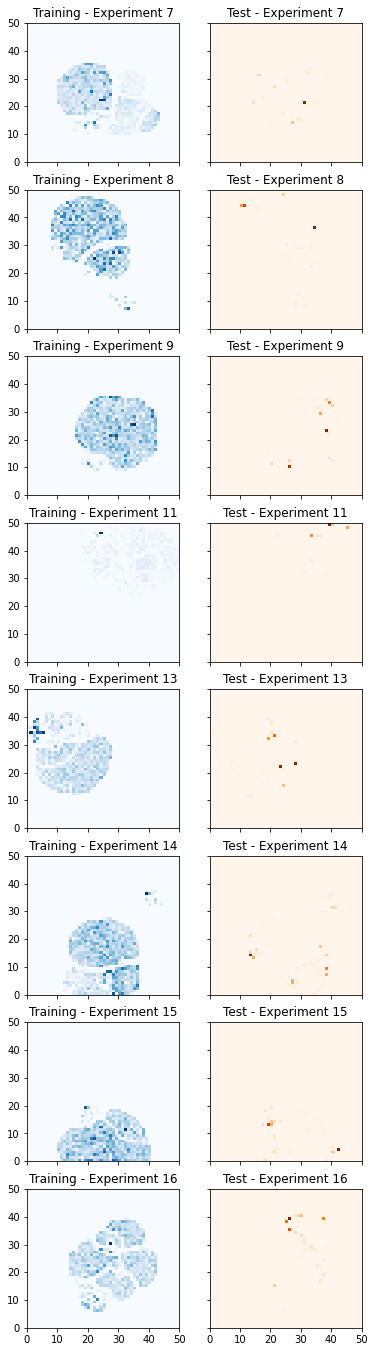

In [10]:
fig, ax = plt.subplots(8, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 24)

for i, file in enumerate(test_files.items()):
    filename, test_file = file
    frequencies = models_som[i].activation_response(train_files[filename].to_numpy())
    ax[i, 0].pcolor(frequencies.T, cmap='Blues')
    ax[i, 0].set_title(f"Training - Experiment {filename}")

    frequencies = models_som[i].activation_response(test_file.to_numpy())
    ax[i, 1].pcolor(frequencies.T, cmap='Oranges')
    ax[i, 1].set_title(f"Test - Experiment {filename}")

plt.savefig(IMAGE_EXPORT_DIRECTORY + "/SOM_act_mat.png", dpi=500)
plt.show()


### Quantization error

In [11]:
%%time
converted_files = [[file[i:i+1].to_numpy() for i in range(len(file) - 1)] for file in files.values()]    # always grab two data points and convert them to numpy (two needed because MiniSom will not evaluate a single one)

quantization_errors = [pd.DataFrame([model.quantization_error(data_point)
                                     for data_point in converted_files[j]])
                       for j, model in enumerate(models_som)]

rolling_medians_som = [qe.rolling(WINDOW).median() for qe in quantization_errors]

print("Quantization errors computed.")

Quantization errors computed.
Wall time: 4min 29s


### Anomaly Localization

In [12]:
%%time
def get_bmu_weights(model, row: pd.Series) -> np.ndarray:
    """Weights of Best Matching Unit"""
    return model._weights[model.winner(row.to_numpy())]
    
def most_diverging_feature(x: pd.Series, bmu_weights: np.ndarray) -> str:
    return (x - bmu_weights).abs().idxmax()

som_anom_loc = [[most_diverging_feature(row, get_bmu_weights(models_som[i], row))
                 for index, row in file.iterrows()]
                for i, file in enumerate(files.values())]
som_anom_loc = [anom_loc[:-1] for anom_loc in som_anom_loc]  # necessary because of how quantization error is computed, so that the dataframes have the same length

print("Computed SOM Anomaly localization.")

Computed SOM Anomaly localization.
Wall time: 2min 12s


### Plots

<ipython-input-7-a1197af37784>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]


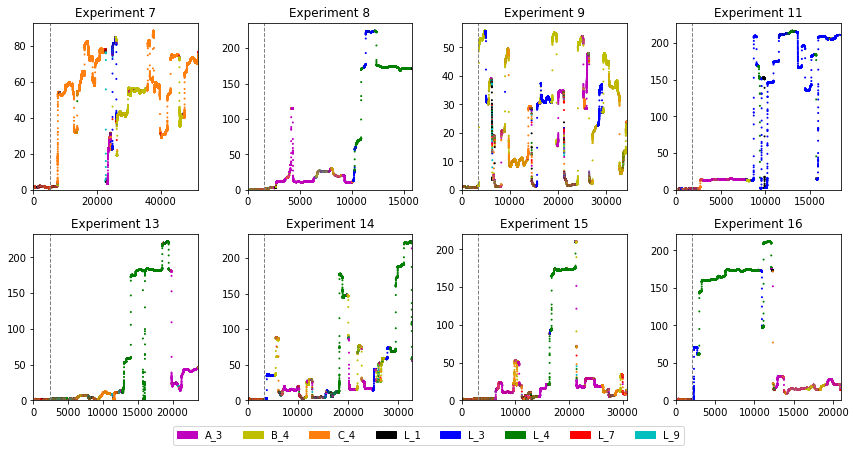

In [21]:
plot_deviation_curve(rolling_medians_som, anomaly_localization=som_anom_loc,
                     experiment_names=list(files.keys()), colormap=COLORMAP,
                     filepath=IMAGE_EXPORT_DIRECTORY + "/SOM_anom_loc.png")

#### Anomaly localization as stackplot

<ipython-input-7-a1197af37784>:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]


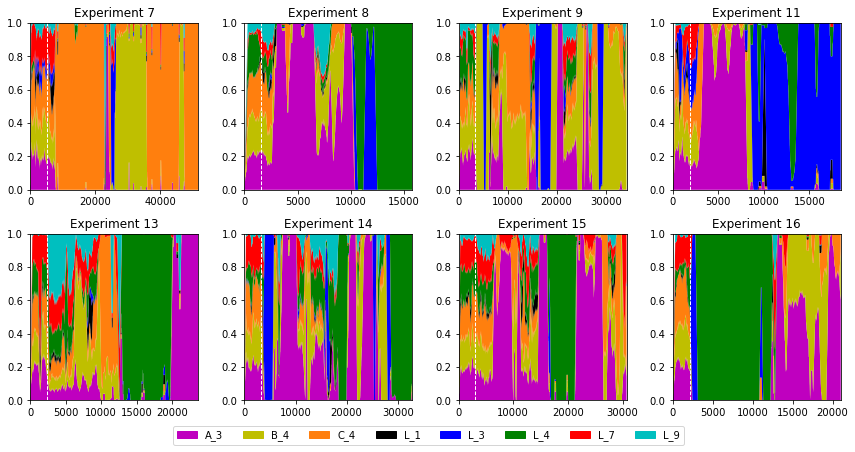

In [22]:
plot_stackplot(som_anom_loc, colormap=COLORMAP,
               experiment_names=list(files.keys()),
               filepath=IMAGE_EXPORT_DIRECTORY + "/SOM_anom_loc_stackplot.png",
               window=WINDOW)

# OneClass SVM

In [15]:
%%time
models_svm = [OneClassSVM(kernel=SVM_KERNEL, nu=SVM_NU).fit(train) for train in train_files.values()]

print("OneClassSVM models fitted.")

OneClassSVM models fitted.
Wall time: 62.5 ms


### Deviation

In [23]:
%%time
predictions_svm = [-1 * pd.DataFrame(models_svm[i].decision_function(file)) for i, file in enumerate(files.values())]

rolling_medians_svm = [pred.rolling(WINDOW).median() for pred in predictions_svm]  # multiply with -1 so that plot has same orientation as SOM plot

print("Deviations from hyperplane computed.")

Deviations from hyperplane computed.
Wall time: 358 ms


### Anomaly Localization

In [17]:
%%time
def get_bmu(x: pd.Series, model: OneClassSVM) -> np.ndarray:
    support_vectors = model.support_vectors_
    distances = np.linalg.norm(support_vectors - x.to_numpy(), axis=1)
    min_index = pd.Series(distances).idxmin()

    return support_vectors[min_index]

def most_diverging_feature(x: pd.Series, model: OneClassSVM) -> str:
    bmu = get_bmu(x, model)
    return (x - bmu).abs().idxmax()

oc_svm_anom_loc = [[most_diverging_feature(row, models_svm[i])
                          for index, row in file.iterrows()]
                         for i, file in enumerate(files.values())]

print("Computed OneClassSVM Anomaly localization.")

Computed OneClassSVM Anomaly localization.
Wall time: 1min 35s


### Plots

<ipython-input-7-a1197af37784>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]


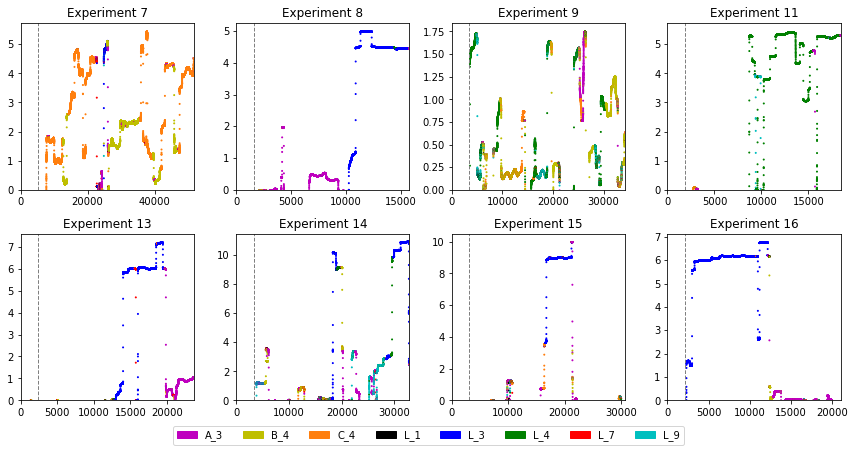

In [24]:
plot_deviation_curve(rolling_medians_svm, anomaly_localization=oc_svm_anom_loc,
                     experiment_names=list(files.keys()), colormap=COLORMAP,
                     filepath=IMAGE_EXPORT_DIRECTORY + "/SVM_anom_loc.png")

#### Anomaly localization as stackplot

<ipython-input-7-a1197af37784>:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]


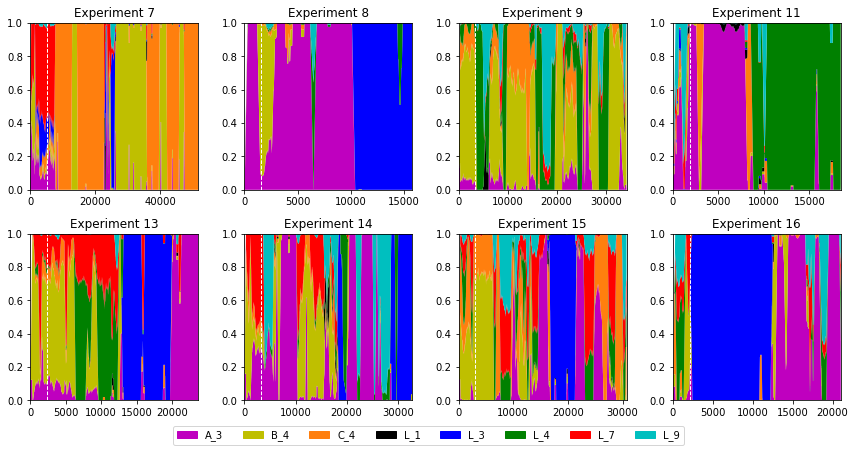

In [25]:
plot_stackplot(oc_svm_anom_loc, colormap=COLORMAP,
               experiment_names=list(files.keys()),
               filepath=IMAGE_EXPORT_DIRECTORY + "/SVM_anom_loc_stackplot.png",
               window=WINDOW)